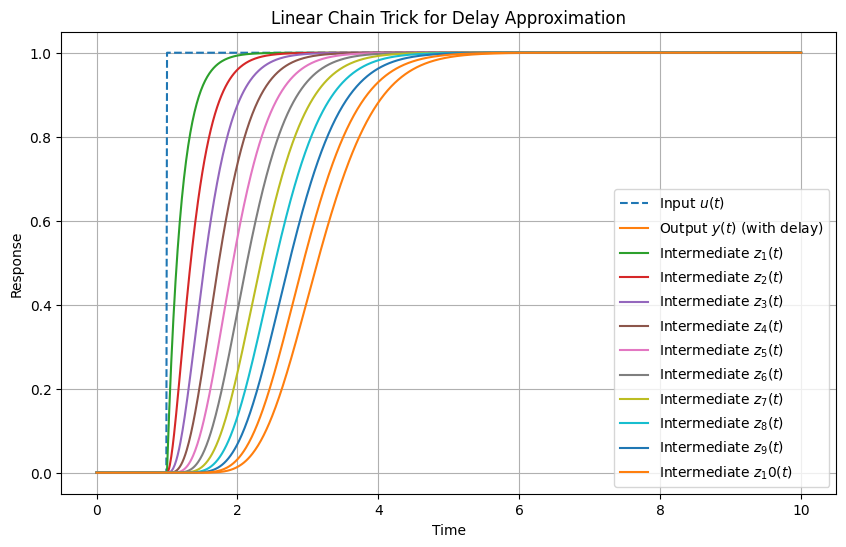

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def linear_chain_trick(y, t, u, n, delay_time):
    dzdt = np.zeros(n + 1)
    k = n / delay_time
    
    dzdt[0] = k * (u(t) - y[0])
    for i in range(1, n):
        dzdt[i] = k * (y[i-1] - y[i])
    dzdt[n] = k * (y[n-1] - y[n])
    
    return dzdt

# Parameters
n = 10            # Number of stages
delay_time = 2.0 # Total delay time
total_time = 10.0
time_steps = 1000

# Time vector
t = np.linspace(0, total_time, time_steps)

# Input function (e.g., step input)
def u(t):
    return 1.0 if t > 1 else 0.0

# Initial conditions
y0 = np.zeros(n + 1)

# Solve the ODE system
solution = odeint(linear_chain_trick, y0, t, args=(u, n, delay_time))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, [u(ti) for ti in t], label='Input $u(t)$', linestyle='--')
plt.plot(t, solution[:, -1], label='Output $y(t)$ (with delay)')
for i in range(n):
    plt.plot(t, solution[:, i], label=f'Intermediate $z_{i+1}(t)$')
plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Linear Chain Trick for Delay Approximation')
plt.legend()
plt.grid(True)
plt.show()


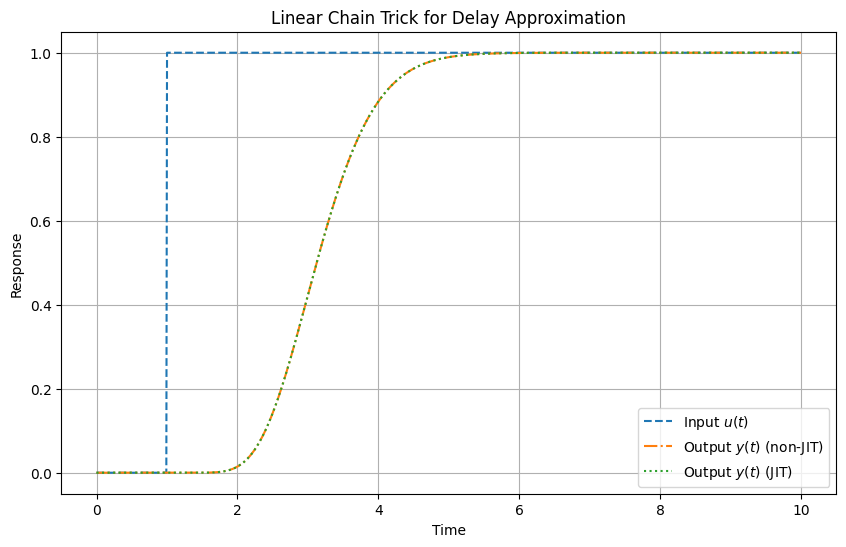

Non-JIT execution time: 0.0850 seconds
JIT execution time: 0.8550 seconds


In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numba import jit
import time

# Non-JIT version of the linear chain trick function
def linear_chain_trick(y, t, n, delay_time, u_val):
    dzdt = np.zeros(n + 1)
    k = n / delay_time
    
    dzdt[0] = k * (u_val - y[0])
    for i in range(1, n):
        dzdt[i] = k * (y[i-1] - y[i])
    dzdt[n] = k * (y[n-1] - y[n])
    
    return dzdt

# JIT-compiled version of the linear chain trick function
linear_chain_trick_jit = jit(nopython=True)(linear_chain_trick)

# Parameters
n = 10            # Number of stages
delay_time = 2.0  # Total delay time
total_time = 10.0
time_steps = 1000

# Time vector
t = np.linspace(0, total_time, time_steps)

# Input function (e.g., step input)
def u(t):
    return 1.0 if t > 1 else 0.0

# Initial conditions
y0 = np.zeros(n + 1)

# Measure the execution time of the non-JIT version
start_time = time.time()
solution = np.zeros((time_steps, n + 1))
for i in range(time_steps):
    u_val = u(t[i])
    if i == 0:
        solution[i] = y0
    else:
        solution[i] = odeint(linear_chain_trick, solution[i-1], [t[i-1], t[i]], args=(n, delay_time, u_val))[-1]
non_jit_time = time.time() - start_time

# Measure the execution time of the JIT version
start_time = time.time()
solution_jit = np.zeros((time_steps, n + 1))
for i in range(time_steps):
    u_val = u(t[i])
    if i == 0:
        solution_jit[i] = y0
    else:
        solution_jit[i] = odeint(linear_chain_trick_jit, solution_jit[i-1], [t[i-1], t[i]], args=(n, delay_time, u_val))[-1]
jit_time = time.time() - start_time

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, [u(ti) for ti in t], label='Input $u(t)$', linestyle='--')
plt.plot(t, solution[:, -1], label='Output $y(t)$ (non-JIT)', linestyle='-.')
plt.plot(t, solution_jit[:, -1], label='Output $y(t)$ (JIT)', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Linear Chain Trick for Delay Approximation')
plt.legend()
plt.grid(True)
plt.show()

# Print execution times
print(f"Non-JIT execution time: {non_jit_time:.4f} seconds")
print(f"JIT execution time: {jit_time:.4f} seconds")


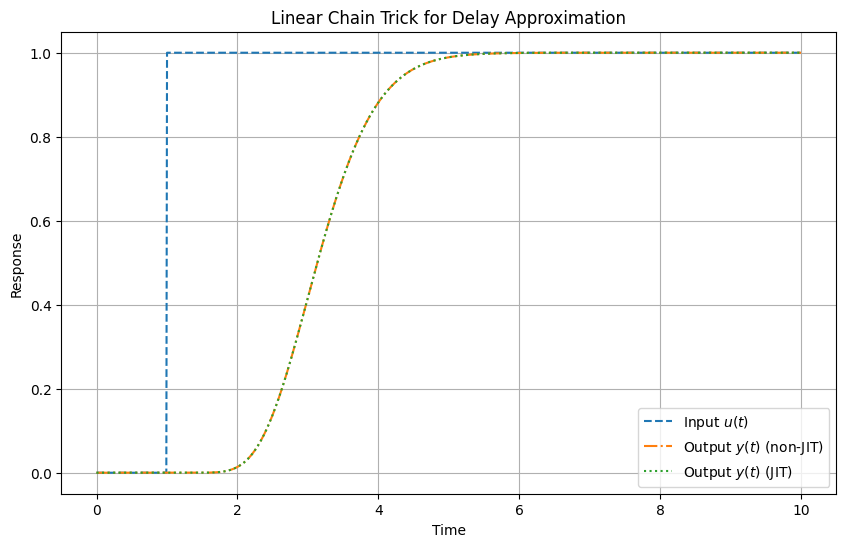

Non-JIT execution time: 0.1000 seconds
JIT execution time: 0.2240 seconds


In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numba import jit
import time

# Define the input function outside the JIT-compiled function
def u(t):
    return 1.0 if t > 1 else 0.0

# Combined function for the linear chain trick with JIT compilation
@jit(nopython=True)
def linear_chain_trick_combined(y, t, n, delay_time):
    dzdt = np.zeros(n + 1)
    k = n / delay_time
    
    u_val = 1.0 if t > 1 else 0.0  # Evaluate the input function here
    dzdt[0] = k * (u_val - y[0])
    for i in range(1, n):
        dzdt[i] = k * (y[i-1] - y[i])
    dzdt[n] = k * (y[n-1] - y[n])
    
    return dzdt

# Parameters
n = 10            # Number of stages
delay_time = 2.0  # Total delay time
total_time = 10.0
time_steps = 1000

# Time vector
t = np.linspace(0, total_time, time_steps)

# Initial conditions
y0 = np.zeros(n + 1)

# Measure the execution time of the non-JIT version
start_time = time.time()
solution = np.zeros((time_steps, n + 1))
for i in range(time_steps):
    if i == 0:
        solution[i] = y0
    else:
        solution[i] = odeint(linear_chain_trick_combined.py_func, solution[i-1], [t[i-1], t[i]], args=(n, delay_time))[-1]
non_jit_time = time.time() - start_time

# Measure the execution time of the JIT version
start_time = time.time()
solution_jit = np.zeros((time_steps, n + 1))
for i in range(time_steps):
    if i == 0:
        solution_jit[i] = y0
    else:
        solution_jit[i] = odeint(linear_chain_trick_combined, solution_jit[i-1], [t[i-1], t[i]], args=(n, delay_time))[-1]
jit_time = time.time() - start_time

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, [u(ti) for ti in t], label='Input $u(t)$', linestyle='--')
plt.plot(t, solution[:, -1], label='Output $y(t)$ (non-JIT)', linestyle='-.')
plt.plot(t, solution_jit[:, -1], label='Output $y(t)$ (JIT)', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Linear Chain Trick for Delay Approximation')
plt.legend()
plt.grid(True)
plt.show()

# Print execution times
print(f"Non-JIT execution time: {non_jit_time:.4f} seconds")
print(f"JIT execution time: {jit_time:.4f} seconds")


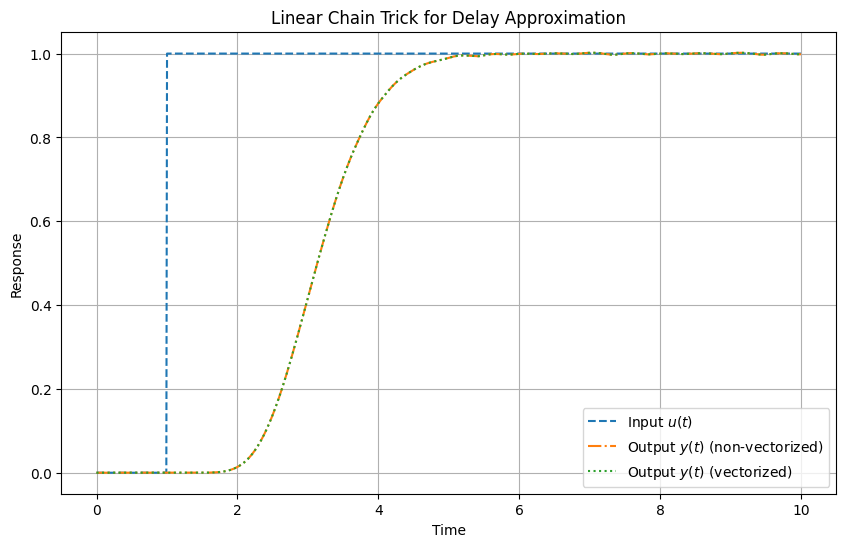

Non-vectorized execution time: 0.0090 seconds
Vectorized execution time: 0.0080 seconds


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

# Non-vectorized version of the linear chain trick function
def linear_chain_trick(t, y, n, delay_time, u):
    dzdt = np.zeros(n + 1)
    k = n / delay_time
    
    dzdt[0] = k * (u(t) - y[0])
    for i in range(1, n):
        dzdt[i] = k * (y[i-1] - y[i])
    dzdt[n] = k * (y[n-1] - y[n])
    
    return dzdt

# Vectorized version of the linear chain trick function
def linear_chain_trick_vectorized(t, y, n, delay_time, u):
    k = n / delay_time
    dzdt = np.zeros(n + 1)
    dzdt[0] = k * (u(t) - y[0])
    dzdt[1:] = k * (y[:-1] - y[1:])
    return dzdt

# Parameters
n = 10            # Number of stages
delay_time = 2.0  # Total delay time
total_time = 10.0
time_steps = 1000

# Time vector
t = np.linspace(0, total_time, time_steps)

# Input function (e.g., step input)
def u(t):
    return 1.0 if t > 1 else 0.0

# Initial conditions
y0 = np.zeros(n + 1)

# Measure the execution time of the non-vectorized version
start_time = time.time()
solution_non_vectorized = solve_ivp(linear_chain_trick, [0, total_time], y0, t_eval=t, args=(n, delay_time, u))
non_vectorized_time = time.time() - start_time

# Measure the execution time of the vectorized version
start_time = time.time()
solution_vectorized = solve_ivp(linear_chain_trick_vectorized, [0, total_time], y0, t_eval=t, args=(n, delay_time, u))
vectorized_time = time.time() - start_time

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, [u(ti) for ti in t], label='Input $u(t)$', linestyle='--')
plt.plot(solution_non_vectorized.t, solution_non_vectorized.y[-1], label='Output $y(t)$ (non-vectorized)', linestyle='-.')
plt.plot(solution_vectorized.t, solution_vectorized.y[-1], label='Output $y(t)$ (vectorized)', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Response')
plt.title('Linear Chain Trick for Delay Approximation')
plt.legend()
plt.grid(True)
plt.show()

# Print execution times
print(f"Non-vectorized execution time: {non_vectorized_time:.4f} seconds")
print(f"Vectorized execution time: {vectorized_time:.4f} seconds")
